In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle

import matplotlib.pyplot as plt
import cv2

In [7]:
#Load all models
haar = cv2.CascadeClassifier('./model/haarcascade_frontalface_default.xml')
model_svm = pickle.load(open('./model/model_svm.pickle',mode='rb'))
pca_models = pickle.load(open('./model/pca_dict.pickle', mode='rb'))

In [8]:
model_pca = pca_models['pca']
mean_face_arr = pca_models['mean_face']

In [41]:
# step 1: read image
img = cv2.imread('./test_images/getty_test.jpg')
# step 2: convert into gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# step 3: crop the faces 
faces = haar.detectMultiScale(gray, 1.5, 3)
predictions = []

for x,y,w,h in faces:
    roi = gray[y:y+h,x:x+w]
    
    # step-04: normalization (0-1)
    roi = roi / 255.0
    # step-05: resize images (100,100)
    if roi.shape[1] > 100:
        roi_resize = cv2.resize(roi, (100,100), cv2.INTER_AREA)
    else:
        roi_resize = cv2.resize(roi, (100,100), cv2.INTER_CUBIC)
    
    # step-06: Flattening (1x10000)
    roi_reshape = roi_resize.reshape(1, 10000)
    
    # step-07: subtract with mean
    roi_mean = roi_reshape - mean_face_arr
    
    # step-08: get eigen image
    eigen_image = model_pca.transform(roi_mean)
    
    # step-09 Eigen Image for Visualization
    eig_img = model_pca.inverse_transform(eigen_image)
    
    # step-10: pass to ml model (sum) and get predictions
    results = model_svm.predict(eigen_image)
    prob_score = model_svm.predict_proba(eigen_image)
    prob_score_max = prob_score.max()
    
    # step-11: generate report
    text = "%s : %d"%(results[0], prob_score_max*100)
    
    #defining color based on results
    if results[0] == 'male':
        color = (255,255,0)
    else: 
        color = (255,0,255)
        
    cv2.rectangle(img,(x,y),(x+w,y+h),color,2)
    cv2.rectangle(img, (x,y-40),(x+w,y), color, -1)
    cv2.putText(img, text, (x,y), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255),5)
    output = {
        'roi': roi,
        'eig_img': eig_img,
        'prediction_name': results[0],
        'score': prob_score_max
    }
    predictions.append(output)

In [42]:
predictions

[{'roi': array([[0.54117647, 0.56078431, 0.58823529, ..., 0.64313725, 0.63529412,
          0.63137255],
         [0.58431373, 0.6       , 0.61568627, ..., 0.62352941, 0.63137255,
          0.64313725],
         [0.59607843, 0.61568627, 0.63137255, ..., 0.61568627, 0.62352941,
          0.63137255],
         ...,
         [0.6       , 0.59607843, 0.58039216, ..., 0.9372549 , 0.93333333,
          0.93333333],
         [0.59607843, 0.59215686, 0.57647059, ..., 0.93333333, 0.93333333,
          0.93333333],
         [0.59215686, 0.58823529, 0.57647059, ..., 0.92941176, 0.92941176,
          0.93333333]]),
  'eig_img': array([[0.17024184, 0.17118064, 0.19227649, ..., 0.34485726, 0.35105955,
          0.34468485]]),
  'prediction_name': 'male',
  'score': 0.9326901902586723},
 {'roi': array([[0.6       , 0.60784314, 0.61960784, ..., 0.57254902, 0.57647059,
          0.58039216],
         [0.61568627, 0.61960784, 0.62352941, ..., 0.57254902, 0.57647059,
          0.57647059],
         [0.65

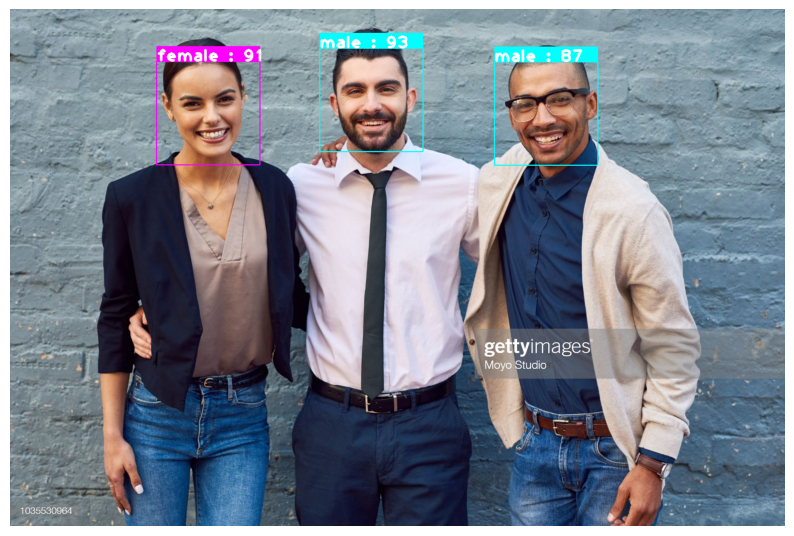

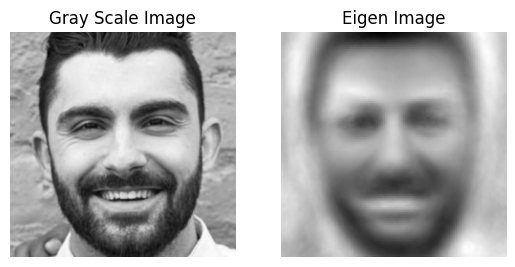

Predicted Gender =  male
Predicted score = 93.27 %
----------------------------------------------------------------------------------------------------


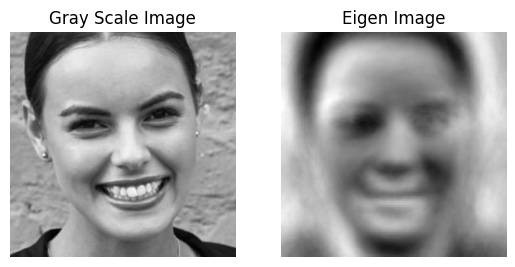

Predicted Gender =  female
Predicted score = 91.36 %
----------------------------------------------------------------------------------------------------


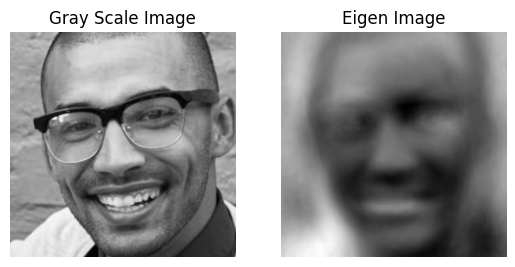

Predicted Gender =  male
Predicted score = 87.02 %
----------------------------------------------------------------------------------------------------


In [50]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

### generate report
for i in range(len(predictions)):
    obj_gray = predictions[i]['roi'] #gray scale
    obj_eig = predictions[i]['eig_img'].reshape(100,100) #eigen image
    plt.subplot(1,2,1)
    plt.imshow(obj_gray, cmap='gray')
    plt.title('Gray Scale Image')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(obj_eig, cmap='gray')
    plt.title('Eigen Image')
    plt.axis('off')
    
    plt.show()
    print('Predicted Gender = ', predictions[i]['prediction_name'])
    print('Predicted score = {:,.2f} %'.format(predictions[i]['score']*100))
    
    print('-'*100)